In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Generate full grid of training data
Space_width = 2
Number_of_grid = 160 # 160 is a good number on Colab free tier. Perhaps we can try 320
target_volume = 0.1
length_scale = tf.pow(target_volume, 1/3) # rough estimate of the drop size
TCL_height = length_scale / 100           # thickness of the wedge near the contact line

x_full = np.linspace(-Space_width/2, Space_width/2, Number_of_grid)
y_full = np.linspace(-Space_width/2, Space_width/2, Number_of_grid)
x_grid, y_grid = np.meshgrid(x_full, y_full)

# Compute radial distances
r_grid = np.sqrt(x_grid**2 + y_grid**2)

# Convert grid points to tensor once
xy_full = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy_full_tensor = tf.convert_to_tensor(xy_full, dtype=tf.float32)



# Define neural network
model = Sequential([
    Input(shape=(2,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(1, activation='linear')
])

# Define a trainable variable for the Laplace pressure
laplace_pressure = tf.Variable(0.1, dtype=tf.float32, trainable=True)
laplace_pressure.assign(-(2.0/np.sqrt(3)) / length_scale)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=-2.487727>

In [ ]:

# Global contact mask memory (initialized once, as the loss term cannot run without this set)
# contact_mask_memory is the set of points that compose the contact line group
contact_mask_memory = tf.Variable(tf.zeros_like(xy_full_tensor[:, 0]), trainable=False, dtype=tf.float32)
# z_old_memory is the z heights of those points.
z_old_memory = tf.Variable(tf.zeros_like(xy_full_tensor[:, 0]), trainable=False, dtype=tf.float32)

from tensorflow.keras.models import load_model

# Load the model
model = load_model('./models/my_pinn_model_bo3_tilt30.keras')

# Load the saved variables
data = np.load('./models/my_pinn_state_bo3_tilt30.npz')
laplace_pressure.assign(data['laplace_pressure'])
contact_mask_memory.assign(data['contact_mask_memory'])
z_old_memory.assign(data['z_old_memory'])



Saving my_pinn_model_bo3_tilt30.keras to my_pinn_model_bo3_tilt30 (6).keras
Saving my_pinn_state_bo3_tilt30.npz to my_pinn_state_bo3_tilt30 (6).npz


<tf.Variable 'UnreadVariable' shape=(25600,) dtype=float32, numpy=
array([-1.2529978, -1.2516173, -1.2501274, ..., -1.9627477, -1.978429 ,
       -1.9946017], dtype=float32)>

In [3]:
# this warm-up block is used only if you don't have a saved model.

# Define optimizer first
optimizer_warmup = Adam(learning_rate=1e-4)

# Warmup training to make a drop-ish shape
def spherical_cap_height(xy_tensor):
    x = xy_tensor[:, 0]
    y = xy_tensor[:, 1]
    r2 = tf.square(x) + tf.square(y)
    R = tf.constant(0.5, dtype=tf.float32)
    H0 = tf.constant(0.2, dtype=tf.float32)
    h = H0 * (1 - r2 / tf.square(R))
    return tf.maximum(h, -0.5)

def warmup_model(epochs=3000):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:  # No need for persistent=True here
            target_z = spherical_cap_height(xy_full_tensor)
            z_pred = model(xy_full_tensor)
            warmup_loss = tf.reduce_mean(tf.square(z_pred[:, 0] - target_z))

        # Only train the model (not laplace_pressure)
        grads = tape.gradient(warmup_loss, model.trainable_variables)
        optimizer_warmup.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 200 == 0:
            print(f"Epoch {epoch+1}: WarmupL={warmup_loss.numpy():.6f}")

warmup_model(epochs = 1000)

Epoch 1: WarmupL=0.158511
Epoch 201: WarmupL=0.056584
Epoch 401: WarmupL=0.055761
Epoch 601: WarmupL=0.055099
Epoch 801: WarmupL=0.054035


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


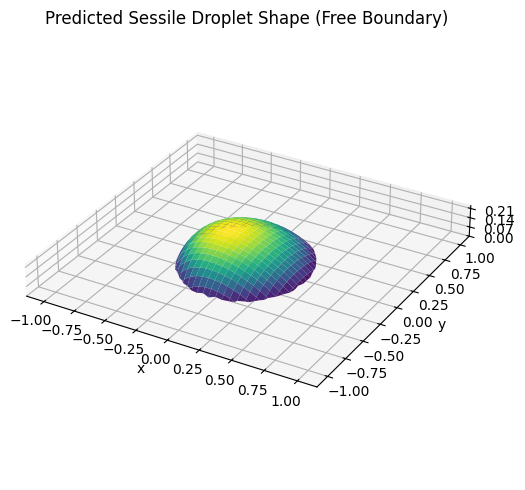

In [4]:
# this block is to quickly examine the shape of the drop.

# Predict and reshape
z_pred = model.predict(xy_full_tensor).ravel()
z_full = np.reshape(z_pred, (Number_of_grid, Number_of_grid))


# Mask: Only show regions where z is significantly above 0 (i.e., part of the drop)
epsilon = 1e-4
z_masked = np.ma.masked_where(z_full < epsilon, z_full)

# Plot surface
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_masked, cmap='viridis')
ax.set_title('Predicted Sessile Droplet Shape (Free Boundary)')
plt.xlabel('x')
plt.ylabel('y')

# Equal aspect ratio for x, y, z
x_range = x_grid.max() - x_grid.min()
y_range = y_grid.max() - y_grid.min()
z_range = z_masked.max() - z_masked.min()
scaling_factor = max(x_range, y_range, z_range)
ax.set_box_aspect([x_range / scaling_factor, y_range / scaling_factor, z_range / scaling_factor])

# Adjust Z-axis tick spacing and limits
z_min = 0.0  # start at zero as you want
z_max = 0.21
z_margin = 0.1 * (z_max - z_min)

ax.set_zlim(z_min, z_max + z_margin)
ax.set_zticks(np.linspace(z_min, z_max, 4))



plt.tight_layout()
plt.show()

In [ ]:
# Custom training loop implementing Young-Laplace equation with gravity and contact angle hysteresis
hysteresis_low = tf.constant(np.tan(np.radians(20)), dtype=tf.float32)
hysteresis_high = tf.constant(np.tan(np.radians(89)), dtype=tf.float32)

Bo = tf.constant(2.9, dtype=tf.float32)  # Bond number for gravity effect


Space_width = 2
Number_of_grid = 160
target_volume = 0.1
length_scale = tf.pow(target_volume, 1/3) # rough estimate of the drop size
TCL_height = length_scale / 100           # thickness of the wedge near the contact line

# we used a fixed set of points to model hysteresis. It is possible to use Monte Carlo method, as described in the paper.
x_full = np.linspace(-Space_width/2, Space_width/2, Number_of_grid)
y_full = np.linspace(-Space_width/2, Space_width/2, Number_of_grid)
x_grid, y_grid = np.meshgrid(x_full, y_full)

# Convert grid points to tensor once
xy_full = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy_full_tensor = tf.convert_to_tensor(xy_full, dtype=tf.float32)

optimizer_full = Adam(learning_rate=1e-4)
k_mask = 80.0  # Sharpness of sigmoid mask
target_slope = (hysteresis_high + hysteresis_low)/2
tilt_angle_deg = 30  # degrees
tilt_angle_rad = np.radians(tilt_angle_deg)
sin_alpha = tf.constant(np.sin(tilt_angle_rad), dtype=tf.float32)

# Custom training loop implementing Young-Laplace equation with volume and dynamic contact line
def train_model(epochs=30):

    for epoch in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            # Compute loss
            tape.watch([laplace_pressure])
            tape.watch(xy_full_tensor)  # Now TensorFlow tracks xy_full_tensor
            z_pred = model(xy_full_tensor)
            z = tf.reshape(z_pred, (-1,))

            # Compute gradients using automatic differentiation
            dz_dx = tape.gradient(z, xy_full_tensor)[:, 0]
            dz_dy = tape.gradient(z, xy_full_tensor)[:, 1]
            d2z_dx2 = tape.gradient(dz_dx, xy_full_tensor)[:, 0]
            d2z_dy2 = tape.gradient(dz_dy, xy_full_tensor)[:, 1]
            d2z_dxdy = tape.gradient(dz_dy, xy_full_tensor)[:, 0]

            # Soft mask based on height
            mask_soft = tf.sigmoid(k_mask * z)
            mask_ring = tf.sigmoid(k_mask * (z)) - tf.sigmoid(k_mask * (z - TCL_height))  # ~contact line zone

            grad_mag = tf.sqrt(dz_dx**2 + dz_dy**2 + 1e-8)
            angle_loss = tf.reduce_sum(
                mask_ring * tf.square(tf.nn.relu(grad_mag - hysteresis_high)) +
                mask_ring * tf.square(tf.nn.relu(hysteresis_low - grad_mag))
            ) / (tf.reduce_sum(mask_ring) + 1e-6)

            # PDE loss (mean curvature - pressure)
            denominator = (1 + dz_dx**2 + dz_dy**2)**(3/2)
            numerator = (1 + dz_dy**2) * d2z_dx2 - 2 * dz_dx * dz_dy * d2z_dxdy + (1 + dz_dx**2) * d2z_dy2
            curvature = numerator / (denominator + 1e-6)
            x = xy_full_tensor[:, 0]
            hydrostatic_term = z + x * sin_alpha
            laplace_residual = curvature - ( laplace_pressure + (Bo/length_scale**2) * hydrostatic_term )

            # Gravity term added
            pde_loss = tf.reduce_sum(mask_soft * tf.square(laplace_residual)) / (tf.reduce_sum(mask_soft) + 1e-6)
            laplace_mean = tf.reduce_sum(mask_soft * (numerator / (denominator + 1e-6))) / (tf.reduce_sum(mask_soft) + 1e-6)

            # Memory-based motion penalty
            contact_mask_now = tf.cast((z >= 0.0) & (z < TCL_height), tf.float32)
            moved_mask = tf.abs(contact_mask_memory - contact_mask_now)

            # Contact line velocity: difference in height from previous epoch
            v_CL = z - z_old_memory

            # Define directional motion masks only where contact line moved
            advancing_mask = tf.cast((grad_mag > hysteresis_high) & (v_CL > 0), tf.float32)
            receding_mask = tf.cast((grad_mag < hysteresis_low) & (v_CL < 0), tf.float32)
            allowed_motion = advancing_mask + receding_mask

            # Apply directional filtering only to regions where contact status changed
            direction_penalty_mask = moved_mask * (1.0 - allowed_motion)
            w_z = tf.clip_by_value(1.0 - z / TCL_height, 0.0, 1.0)

            # Directional hysteresis loss
            direction_loss = tf.reduce_sum(direction_penalty_mask * w_z * tf.square(v_CL)) / (
                tf.reduce_sum(direction_penalty_mask) + 1e-6)

            # Volume constraint (only inside the contact line)
            dx = Space_width / Number_of_grid  # Grid spacing in x and y
            dy = Space_width / Number_of_grid
            cell_area = dx * dy  # Each grid point represents this much area
            volume = tf.reduce_sum(mask_soft * z) * cell_area
            volume_loss = tf.square(volume - target_volume)

            # Soft constraint to stabilize the drop near the center.
            x = xy_full_tensor[:, 0]
            y = xy_full_tensor[:, 1]
            mass = mask_soft * z  # soft mask × height = "mass"

            total_mass = tf.reduce_sum(mass) + 1e-6
            x_com = tf.reduce_sum(mass * x) / total_mass
            y_com = tf.reduce_sum(mass * y) / total_mass

            center_loss = tf.square(x_com) + tf.square(y_com)
            y_loss = tf.square(y_com)

            normalized_pde_loss = pde_loss / (tf.square(laplace_mean) + 1e-6)
            normalized_angle_loss = angle_loss / tf.square(target_slope)
            normalized_volume_loss = volume_loss / tf.square(target_volume)
            normalized_direction_loss =direction_loss / tf.square(TCL_height/1)


            total_loss = (
                10**3 * normalized_pde_loss +
                10**3 * normalized_angle_loss +
                10**4 * normalized_volume_loss +
                0 * center_loss +
                100 * y_loss +
                100 * normalized_direction_loss
            )

        # Compute gradients for model parameters and custom variables
        trainable_vars = model.trainable_variables + [laplace_pressure]
        gradients = tape.gradient(total_loss, trainable_vars)
        optimizer_full.apply_gradients(zip(gradients, trainable_vars))
        if epoch % 10 == 0:  # Only print every 10 epochs
            print(f"Epoch {epoch+1}: Volume={volume.numpy()}, Laplace(C/A)={laplace_pressure.numpy()}, {laplace_mean.numpy()}")
            print(f"Epoch {epoch+1}: PDEL={normalized_pde_loss.numpy()}, AngleL={normalized_angle_loss.numpy()}")
            print(f"Epoch {epoch+1}: DirecL={normalized_direction_loss.numpy()}, VolL={normalized_volume_loss.numpy()}")
            # Example usage
            z_np = z.numpy().reshape(Number_of_grid, Number_of_grid)
            laplace_np = curvature.numpy().reshape(Number_of_grid, Number_of_grid)
            required_curvature = laplace_pressure + (Bo/length_scale**2) * hydrostatic_term
            required_curvature_np = required_curvature.numpy().reshape(Number_of_grid, Number_of_grid)
            z_mask = z_np >= 0

        # print("Trainable variables:", [v.name for v in trainable_vars])

        contact_mask_memory.assign(contact_mask_now)
        z_old_memory.assign(z)

# Run training loop
train_model(epochs=1000)

In [ ]:
model_save_path = 'INSERT PATH HERE'
var_save_path = 'INSERT PATH HERE'

model.save(model_save_path)

np.savez(var_save_path,
         laplace_pressure=laplace_pressure.numpy(),
         contact_mask_memory=contact_mask_memory.numpy(),
         z_old_memory=z_old_memory.numpy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


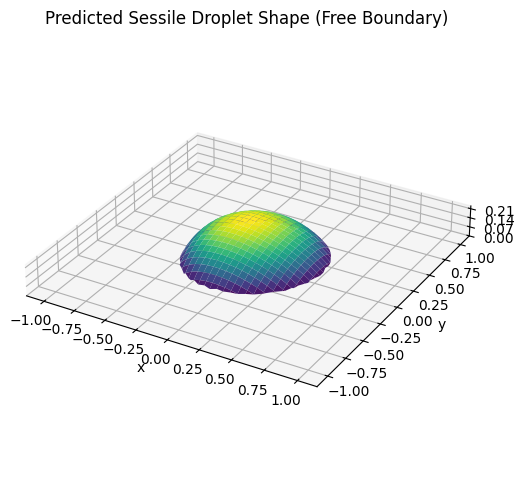

In [28]:
# Predict and reshape
z_pred = model.predict(xy_full_tensor).ravel()
z_full = np.reshape(z_pred, (Number_of_grid, Number_of_grid))

# Mask: Only show regions where z is significantly above 0 (i.e., part of the drop)
epsilon = 1e-4
z_masked = np.ma.masked_where(z_full < epsilon, z_full)

# Plot surface
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_masked, cmap='viridis')
ax.set_title('Predicted Sessile Droplet Shape (Free Boundary)')
plt.xlabel('x')
plt.ylabel('y')

# Equal aspect ratio for x, y, z
x_range = x_grid.max() - x_grid.min()
y_range = y_grid.max() - y_grid.min()
z_range = z_masked.max() - z_masked.min()
scaling_factor = max(x_range, y_range, z_range)
ax.set_box_aspect([x_range / scaling_factor, y_range / scaling_factor, z_range / scaling_factor])

# Adjust Z-axis tick spacing and limits
z_min = 0.0  # start at zero as you want
z_max = 0.21
z_margin = 0.1 * (z_max - z_min)

ax.set_zlim(z_min, z_max + z_margin)
ax.set_zticks(np.linspace(z_min, z_max, 4))



plt.tight_layout()
plt.show()


800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


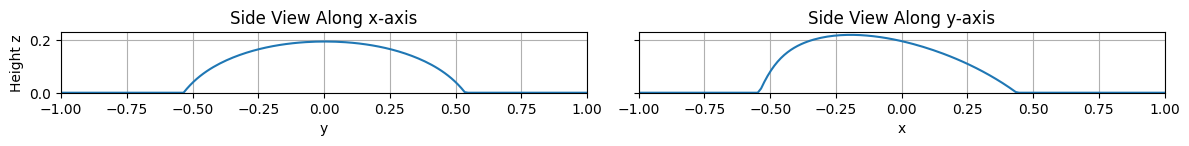

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data (replace with model prediction if available)
Number_of_grid = 160

Space_width = 2
x_full = np.linspace(-Space_width / 2, Space_width / 2, Number_of_grid)
y_full = np.linspace(-Space_width / 2, Space_width / 2, Number_of_grid)
x_grid, y_grid = np.meshgrid(x_full, y_full)
r_grid = np.sqrt(x_grid**2 + y_grid**2)
# Convert grid points to tensor once
xy_full = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
xy_full_tensor = tf.convert_to_tensor(xy_full, dtype=tf.float32)

z_pred = model.predict(xy_full_tensor).ravel()
z_full = np.reshape(z_pred, (Number_of_grid, Number_of_grid))

# Slice through center for side views
center_x_index = Number_of_grid // 2
center_y_index = Number_of_grid // 2
z_y_slice = np.maximum(0.0, z_full[:, center_x_index])
z_x_slice = np.maximum(0.0, z_full[center_y_index, :])

# Determine global z limits for consistent axis
z_max = max(np.max(z_y_slice), np.max(z_x_slice))
z_min = 0.0

# Compute finite differences to estimate local slopes
def estimate_max_angle(profile, coords):
    dz = np.diff(profile)
    dx = np.diff(coords)
    slopes = dz / (dx + 1e-8)
    max_slope = np.max(np.abs(slopes))
    return np.degrees(np.arctan(max_slope))

angle_x_max = estimate_max_angle(z_x_slice, x_full)
angle_y_max = estimate_max_angle(z_y_slice, y_full)


# Create side view plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# x-axis side view
axs[0].plot(y_full, z_y_slice, label='Slice at x=0')
axs[0].set_title('Side View Along x-axis')
axs[0].set_xlabel('y')
axs[0].set_ylabel('Height z')
axs[0].set_xlim(y_full[0], y_full[-1])
axs[0].set_ylim(z_min, z_max * 1.05)
axs[0].set_aspect('equal')
axs[0].grid(True)
# axs[0].annotate(f"{angle_y_max:.1f}°", xy=(y_full[0]+0.02, z_y_slice[0]+0.01),
#                fontsize=14)  #  larger than default

# y-axis side view
axs[1].plot(x_full, z_x_slice, label='Slice at y=0')
axs[1].set_title('Side View Along y-axis')
axs[1].set_xlabel('x')
axs[1].set_xlim(x_full[0], x_full[-1])
axs[1].set_ylim(z_min, z_max * 1.05)
axs[1].set_aspect('equal')
axs[1].grid(True)
# axs[1].annotate(f"{angle_x_max:.1f}°", xy=(x_full[0]+0.02, z_x_slice[0]+0.01),
#                 fontsize=14)  #  larger than default

plt.tight_layout()
plt.show()


In [6]:
# Compute numerical gradients
dz_dx = np.gradient(z_x_slice, x_full)  # derivative along x at y=0
dz_dy = np.gradient(z_y_slice, y_full)  # derivative along y at x=0

# Find max absolute slopes near each edge (within a few grid points)
edge_n = 5  # number of points to consider at each end

slope_x_max = abs(dz_dx.max())
slope_x_min = abs(dz_dx.min())

# Convert slopes to contact angles (in degrees)
angle_x = np.degrees(np.arctan(slope_x_max))
angle_y = np.degrees(np.arctan(slope_x_min))

print(f"Estimated contact angle along x-axis (left side): {angle_x:.2f}°")
print(f"Estimated contact angle along x-axis (right side): {angle_y:.2f}°")


Estimated contact angle along x-axis (left side): 62.61°
Estimated contact angle along x-axis (right side): 35.14°
